<a href="https://colab.research.google.com/github/yongshidanke/pytorch_learning/blob/main/day02/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##环境准备##
import torch  #pytorch核心库（tensor，autograd, nn.module)
import torchvision #计算机视觉库（预训练-ResNEt，数据集-CIFAR-10，图像变换工具-transforms）
import torchvision.transforms as transforms   #图像预处理工具集（normalize，resize，randomhorizontalflip）
import torch.nn as nn #pytorch神经网络模块（层定义，激活函数，损失函数）
import torch.optim as optim #优化算法库（优化器，学习率调度器）
import matplotlib.pyplot as plt #可视化
import numpy as np#与numpy转换

# 检查GPU是否可用
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
# #数据预处理##

transform_train = transforms.Compose([#训练集预处理
    transforms.RandomHorizontalFlip(),#随即反转图像；增加多样性
    transforms.RandomCrop(32, padding=4) ,#32*32，填充4个padding像素，在裁剪；模拟不同视角
    transforms.ToTensor(),#将图像转换为张量格式
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),#标准化（mean均值,std标准差)，RGB三通道
])

transform_test = transforms.Compose([ #测试集预处理
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
##数据加载##

# 加载数据集
trainset = torchvision.datasets.CIFAR10(
    root'./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128 , shuffle=True , num_workers=2)
#加载测试集
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

#train：true训练集，false测试集；
#shuffle：true每个epoch打乱顺序
#num_workers：子进程数目
#transform：训练工具
#batch_size：每个bacth处理图像数，epoch为所有batch处理完的一个循环

# CIFAR-10类别标签
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')         #训练&测试集图像类别



100%|██████████| 170M/170M [00:02<00:00, 77.6MB/s]


In [3]:
##定义resnet残差网络##

class SimpleResNet(nn.Module):#定义分类模型
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)#输入3通道，输出64通道
        self.bn1 = nn.BatchNorm2d(64)#输出批归一化
        self.relu = nn.ReLU()#激活函数，引入非线性
        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
        )
        self.fc = nn.Linear(64, 10)  # 分类层，64维映射到10类

def forward(self, x):
    x = self.conv1(x) # [batch, 3, 32, 32] → [batch, 64, 32, 32]
    x = self.bn1(x)  # 批归一化
    x = self.relu(x)  # ReLU激活
    residual = x            # 保存残差连接
    x = self.layer1(x)         # 残差块计算
    x = x + residual           # 残差连接
    x = nn.functional.avg_pool2d(x, 32)  # 全局平均池化 → [batch, 64, 1, 1]
    x = x.view(x.size(0), -1)  # Flatten → [batch, 64]
    x = self.fc(x)             # 分类 → [batch, 10]
    return x
model = SimpleResNet().to(device)#模型迁移至设备GPU



In [5]:
##用simpleresnet模型训练和测试##

criterion = nn.CrossEntropyLoss()#计算多分类任务的交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=0.001)#自适应动量优化器

# 训练函数
def train(epoch):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()#优化器梯度清零
        outputs = model(inputs)
        loss = criterion(outputs, labels)#计算预测值与真实标签交叉熵
        loss.backward()#计算熵梯度
        optimizer.step()#更新参数

        running_loss += loss.item()#交叉熵累加
        if i % 100 == 99:  # 每100个batch打印一次
            print(f'Epoch: {epoch}, Batch: {i+1}, Loss: {running_loss/100:.3f}')
            running_loss = 0.0

# 测试函数
def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():#禁用梯度计算
        for (images, labels) in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)#返回每行最大值的索引
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {100 * correct / total:.2f}%')

# 训练5个epoch
for epoch in range(5):
    train(epoch)
    test()


Epoch: 0, Batch: 100, Loss: 1.369
Epoch: 0, Batch: 200, Loss: 1.315
Epoch: 0, Batch: 300, Loss: 1.324
Test Accuracy: 43.95%
Epoch: 1, Batch: 100, Loss: 1.261
Epoch: 1, Batch: 200, Loss: 1.277
Epoch: 1, Batch: 300, Loss: 1.252
Test Accuracy: 53.73%
Epoch: 2, Batch: 100, Loss: 1.222
Epoch: 2, Batch: 200, Loss: 1.224
Epoch: 2, Batch: 300, Loss: 1.204
Test Accuracy: 45.78%
Epoch: 3, Batch: 100, Loss: 1.175
Epoch: 3, Batch: 200, Loss: 1.194
Epoch: 3, Batch: 300, Loss: 1.178
Test Accuracy: 50.15%
Epoch: 4, Batch: 100, Loss: 1.167
Epoch: 4, Batch: 200, Loss: 1.156
Epoch: 4, Batch: 300, Loss: 1.147
Test Accuracy: 56.01%


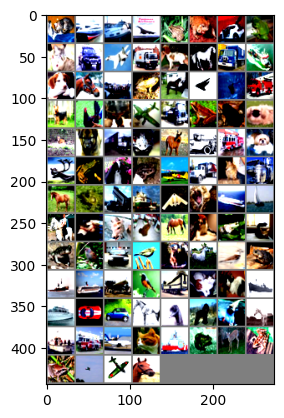

Predicted:  ship  car   ship  ship  frog  frog  car   deer  dog   car  


In [6]:
##显示一批测试图像及其预测结果##

def imshow(img):
    img = img / 2 + 0.5  # 反标准化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  #调整图像通道顺序
    plt.show()

# 随机取一批测试数据（100张）
dataiter = iter(testloader) #将testloader变为迭代器
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# 显示图像
imshow(torchvision.utils.make_grid(images.cpu()))

# 打印预测结果
outputs = model(images)
_, predicted = torch.max(outputs, 1)   #输出每个图片预测的最大概率的索引
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(10)))  #打印前十个预测结果，5s是控制字符串宽度为5